## COMP/ELEC 576 - Final Project

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from d2l import torch as d2l
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset ,DataLoader

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
from pathlib import Path

* Import The Data

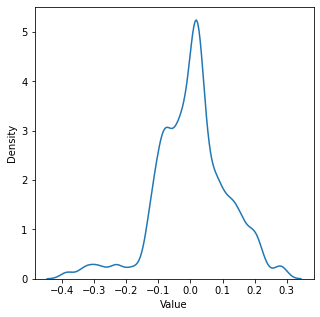

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the csv data
file_path = '/Users/jl259/Desktop/deep_learning_576/project/data_train/ss_PSAT1.csv'
mydata = pd.read_csv(file_path)

# empirical density
plt.figure(figsize = (5, 5))
sns.kdeplot(mydata['BETA'], bw_adjust = 0.5)
# plt.title('Empirical Density Function of Beta')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

* Data Augmentation: Generate Training Data

In [25]:
import numpy as np

m = mydata.shape[0]
n = 10000
keep_rate = 0.9
n_sample = int(n * keep_rate)

data_train = np.zeros((m, n_sample))

for index, row in mydata.iterrows():

    np.random.seed(1)
    samples = np.random.normal(loc = row['BETA'], scale = row['SE'], size = n)
    kept_samples = np.random.choice(samples, size = n_sample, replace = False)

    # training data
    data_train[index, :] = kept_samples

data_train = data_train.T

* Import Reference Panel

In [13]:
file_path = '/Users/jl259/Desktop/deep_learning_576/project/data_train/rp_PSAT1.csv'
rp_data = pd.read_csv(file_path)
rp_data = rp_data.drop(rp_data.columns[0], axis = 1)
rp = rp_data.to_numpy()

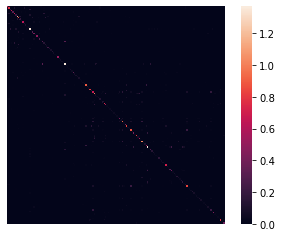

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap
sns.heatmap(rp, square = True)
plt.xticks([])
plt.yticks([])
plt.show()

* Generator and Discriminator

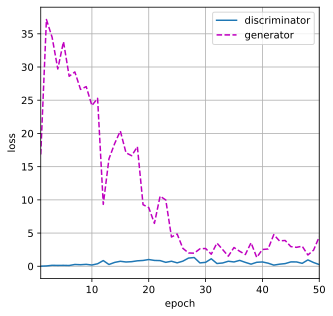

In [39]:
# Generator
class Generator(nn.Module):

    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, m)  
        )

    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(m, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialization
lr_g = 0.0005
lr_d = 0.0005
latent_dim = 200
generator = Generator(latent_dim)
discriminator = Discriminator()

# Optimizers Adam and loss function
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr = lr_g)
optimizer_d = optim.Adam(discriminator.parameters(), lr = lr_d)

# Dataloader
training_data_tensor = torch.Tensor(data_train)
mydata_train = TensorDataset(training_data_tensor)
batch_size = 64
dataloader = DataLoader(mydata_train, batch_size = batch_size, shuffle = True)

# before training
epochs = 50
real_label = 1.
fake_label = 0.

# Training
animator = d2l.Animator(xlabel = 'epoch', ylabel = 'loss',
                        xlim = [1, epochs], nrows = 1, figsize = (5, 5),
                        legend = ['discriminator', 'generator'])
animator.fig.subplots_adjust(hspace = 0.3)

for epoch in range(epochs):

    for i, data in enumerate(dataloader, 0):

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        data = [d.to(device) for d in data]
        input_val = data[0]
        discriminator.zero_grad()
        b_size = input_val.size(0)
        label = torch.full((b_size, ), real_label, dtype = torch.float, device = device)
        output_val = discriminator(input_val).view(-1)
        error_D_real = criterion(output_val, label)
        error_D_real.backward()
        Dx = output_val.mean().item()

        noise = torch.randn(b_size, latent_dim, device = device)
        fake_data = generator(noise)
        label.fill_(fake_label)

        # update discriminator
        output_val = discriminator(fake_data.detach()).view(-1)
        error_D_fake = criterion(output_val, label)
        error_D_fake.backward()
        D_Gz1 = output_val.mean().item()
        error_D = error_D_real + error_D_fake
        optimizer_d.step()

        # update generator
        generator.zero_grad()
        label.fill_(real_label)
        output_val = discriminator(fake_data).view(-1)
        error_G = criterion(output_val, label)
        error_G.backward()
        D_Gz2 = output_val.mean().item()
        optimizer_g.step()

        # Output training stats
        # if i % 50 == 0:
        #    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        #          % (epoch, epochs, i, len(dataloader),
        #             error_D.item(), error_G.item(), Dx, D_Gz1, D_Gz2))
        
    animator.add(epoch + 1, (error_D.item(), error_G.item()))

        

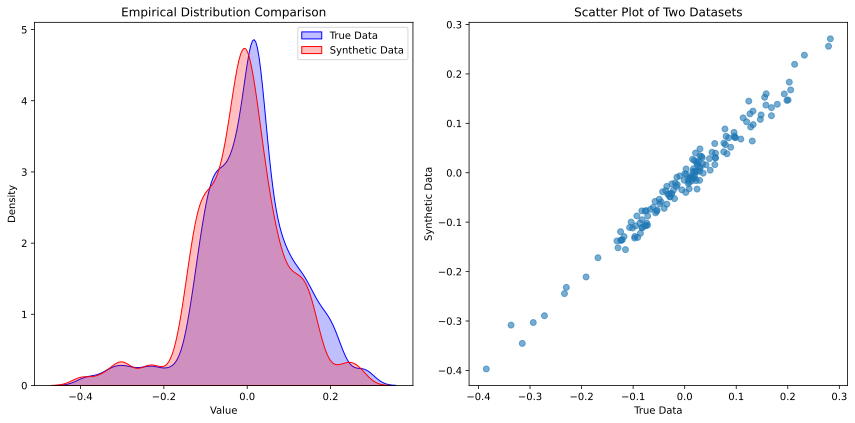

In [40]:
# generate new data and compare with original ones
generator.eval()
noise = torch.randn(1, latent_dim)
with torch.no_grad():
    generated_data = generator(noise)

# plot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

g_data = generated_data.flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Empirical densities
sns.kdeplot(mydata['BETA'], ax = ax1, bw_adjust = 0.6, fill = True, color = "blue", label = "True Data")
sns.kdeplot(g_data, ax = ax1, bw_adjust = 0.6, fill = True, color = "red", label = "Synthetic Data")
ax1.set_title("Empirical Distribution Comparison")
ax1.set_xlabel("Value")
ax1.legend()

# Scatter plot
ax2.scatter(mydata['BETA'], g_data, alpha = 0.6)
ax2.set_title("Scatter Plot of Two Datasets")
ax2.set_xlabel("True Data")
ax2.set_ylabel("Synthetic Data")

plt.tight_layout()
plt.show()

* Conditional GANs

For conditional GANs, we add a layer representing the between-SNPs structure.

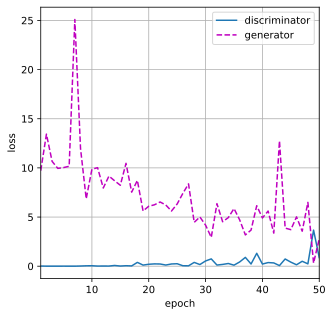

In [69]:
# covariance structure
class CovarianceLayer(nn.Module):
    def __init__(self, covariance_matrix):
        super(CovarianceLayer, self).__init__()
        self.covariance_matrix = nn.Parameter(torch.tensor(covariance_matrix, dtype = torch.float32), requires_grad = False)

    def forward(self, x):
        transformed_x = torch.matmul(x, self.covariance_matrix)
        return transformed_x

# Generator
class Generator(nn.Module):

    def __init__(self, latent_dim, covariance):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, m),
            CovarianceLayer(covariance)
        )

    def forward(self, z):
        return self.model(z)

# Discriminator
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(m, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize models
latent_dim = 200
lr_g = 0.0005
lr_d = 0.001
generator = Generator(latent_dim, rp)
discriminator = Discriminator()

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr = lr_g)
optimizer_d = optim.Adam(discriminator.parameters(), lr = lr_d)

# create dataloader
training_data_tensor = torch.Tensor(data_train)
mydata_train = TensorDataset(training_data_tensor)
batch_size = 64
dataloader = DataLoader(mydata_train, batch_size = batch_size, shuffle = True)

# before training
epochs = 50
real_label = 1.
fake_label = 0.

# Training
animator = d2l.Animator(xlabel = 'epoch', ylabel = 'loss',
                        xlim = [1, epochs], nrows = 1, figsize = (5, 5),
                        legend = ['discriminator', 'generator'])
animator.fig.subplots_adjust(hspace = 0.3)

for epoch in range(epochs):

    for i, data in enumerate(dataloader, 0):

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        data = [d.to(device) for d in data]
        input_val = data[0]
        discriminator.zero_grad()
        b_size = input_val.size(0)
        label = torch.full((b_size, ), real_label, dtype = torch.float, device = device)
        output_val = discriminator(input_val).view(-1)
        error_D_real = criterion(output_val, label)
        error_D_real.backward()
        Dx = output_val.mean().item()

        noise = torch.randn(b_size, latent_dim, device = device)
        fake_data = generator(noise)
        label.fill_(fake_label)

        # update discriminator
        output_val = discriminator(fake_data.detach()).view(-1)
        error_D_fake = criterion(output_val, label)
        error_D_fake.backward()
        D_Gz1 = output_val.mean().item()
        error_D = error_D_real + error_D_fake
        optimizer_d.step()

        # update generator
        generator.zero_grad()
        label.fill_(real_label)
        output_val = discriminator(fake_data).view(-1)
        error_G = criterion(output_val, label)
        error_G.backward()
        D_Gz2 = output_val.mean().item()
        optimizer_g.step()

        # Output training stats
        # if i % 50 == 0:
        #    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        #          % (epoch, epochs, i, len(dataloader),
        #             error_D.item(), error_G.item(), Dx, D_Gz1, D_Gz2))
        
    animator.add(epoch + 1, (error_D.item(), error_G.item()))

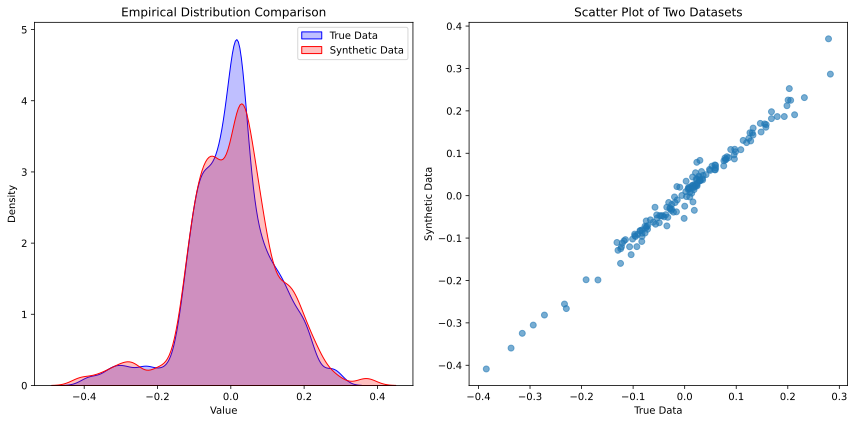

In [70]:
# generate new data and compare with original ones
generator.eval()
noise = torch.randn(1, latent_dim)
with torch.no_grad():
    generated_data = generator(noise)

# plot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

g_data = generated_data.flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Empirical densities
sns.kdeplot(mydata['BETA'], ax = ax1, bw_adjust = 0.6, fill = True, color = "blue", label = "True Data")
sns.kdeplot(g_data, ax = ax1, bw_adjust = 0.6, fill = True, color = "red", label = "Synthetic Data")
ax1.set_title("Empirical Distribution Comparison")
ax1.set_xlabel("Value")
ax1.legend()

# Scatter plot
ax2.scatter(mydata['BETA'], g_data, alpha = 0.6)
ax2.set_title("Scatter Plot of Two Datasets")
ax2.set_xlabel("True Data")
ax2.set_ylabel("Synthetic Data")

plt.tight_layout()
plt.show()